# First Models

## Data Preperation for Poisson Regression Model

### Loading

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime,timedelta
import pandas.api.types as ptypes

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display

from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

In [3]:
status_final = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")
weather_original = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

trips = status_final
weather = weather_original

In [4]:
print("STEP 0 - DataFrames loaded:")
print("trips shape:", trips.shape)
print("weather shape:", weather.shape)

STEP 0 - DataFrames loaded:
trips shape: (22827, 18)
weather shape: (3986, 13)


### STEP 1 - Prepare trips data at hourly resolution

In [5]:
# =========================================================
# STEP 1 - Prepare trips data at hourly resolution
# =========================================================

# 1.1 Ensure start_time is datetime
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')

# 1.2 Keep only trip_start events (if the column exists)
if 'event_types' in trips.columns:
    trips_start_hr = trips[trips['event_types'] == 'trip_start'].copy()
else:
    trips_start_hr = trips.copy()

# 1.3 Floor to hour → this will be the time key for merging with weather
trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')
trips_start_hr['date'] = trips_start_hr['datetime_hour'].dt.date
trips_start_hr['hour'] = trips_start_hr['datetime_hour'].dt.hour  # 0..23

print("\nSTEP 1 - trips_start_hr with datetime_hour/date/hour (sample):")
display(trips_start_hr[['start_time', 'datetime_hour', 'date', 'hour']].head())


STEP 1 - trips_start_hr with datetime_hour/date/hour (sample):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\3045977678.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_start_hr['datetime_hour'] = trips_start_hr['start_time'].dt.floor('H')


,start_time,datetime_hour,date,hour
2,2023-02-05 18:24:34,2023-02-05 18:00:00,2023-02-05,18
4,2023-02-08 17:46:06,2023-02-08 17:00:00,2023-02-08,17
6,2023-02-20 19:14:20,2023-02-20 19:00:00,2023-02-20,19
8,2023-02-01 16:23:19,2023-02-01 16:00:00,2023-02-01,16
9,2023-02-07 22:59:40,2023-02-07 22:00:00,2023-02-07,22


### STEP 2 - Aggregate trips to trips_per_hour (target y)

In [6]:
# =========================================================
# STEP 2A - Prepare hourly weather from raw weather_original
# =========================================================

# Start from the original clean weather dataframe
weather = weather_original.copy()

# Make sure 'datetime' is really datetime dtype
weather['datetime'] = pd.to_datetime(weather['datetime'], errors='coerce')

# Floor to hour resolution
weather['datetime_hour'] = weather['datetime'].dt.floor('H')

# Aggregate to hourly weather
hourly_weather = (
    weather
      .groupby('datetime_hour')
      .agg(
          temp_c      = ('temp_c', 'mean'),
          temp_max_c  = ('temp_max_c', 'mean'),
          temp_min_c  = ('temp_min_c', 'mean'),
          wind_speed_ms = ('wind_speed_ms', 'mean'),
          rain_mm     = ('rain_mm', 'sum'),
      )
      .reset_index()
)

print("\nSTEP 2A - hourly_weather (first rows):")
display(hourly_weather.head())
print("\nSTEP 2A - hourly_weather shape:", hourly_weather.shape)



STEP 2A - hourly_weather (first rows):


C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\2694457965.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather['datetime_hour'] = weather['datetime'].dt.floor('H')


,datetime_hour,temp_c,temp_max_c,temp_min_c,wind_speed_ms,rain_mm
0,2023-02-01 00:00:00,14.233333,15.15,13.25,10.316667,3.5
1,2023-02-01 01:00:00,15.266667,15.65,14.75,11.383333,0.6
2,2023-02-01 02:00:00,15.366667,15.60,15.00,10.216667,0.0
3,2023-02-01 03:00:00,14.450000,15.20,13.95,5.983333,0.0
4,2023-02-01 04:00:00,16.016667,16.15,15.55,8.266667,0.0



STEP 2A - hourly_weather shape: (1994, 6)


In [7]:
# =========================================================
# STEP 2B - Aggregate trips to trips_per_hour (target y)
# =========================================================

hourly_trips = (
    trips_start_hr
    .groupby('datetime_hour')
    .size()
    .rename('trips_per_hour')
    .reset_index()
)

print("\nSTEP 2B - hourly_trips (first rows):")
display(hourly_trips.head())

print("\nSTEP 2B - hourly_trips shape:", hourly_trips.shape)
print("\nSTEP 2B - trips_per_hour summary:")
display(hourly_trips['trips_per_hour'].describe().to_frame(name='trips_per_hour_stats'))



STEP 2B - hourly_trips (first rows):


,datetime_hour,trips_per_hour
0,2023-02-01 00:00:00,1
1,2023-02-01 08:00:00,1
2,2023-02-01 09:00:00,2
3,2023-02-01 10:00:00,2
4,2023-02-01 11:00:00,3



STEP 2B - hourly_trips shape: (1536, 2)

STEP 2B - trips_per_hour summary:


,trips_per_hour_stats
count,1536.000000
mean,6.250000
std,5.481387
min,1.000000
25%,2.000000
50%,5.000000
75%,9.000000
max,35.000000


### STEP 3 - Build full hourly panel and merge trips (with interpolation time based)
Interpolation = fills missing or intermediate values by estimating them from surrounding data points

In [8]:
# =========================================================
# STEP 3 - Build full hourly panel and merge trips (with interpolation)
# =========================================================

from IPython.display import display

# 3.1 Define full hourly range based on weather datetime_hour
start_hour = weather['datetime_hour'].min().floor('H')
end_hour   = weather['datetime_hour'].max().ceil('H')

full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
reg_hourly = pd.DataFrame({'datetime_hour': full_hours})

print("\nSTEP 3 - full_hours created:")
print(reg_hourly.shape)
display(reg_hourly.head(10))

# 3.2 Merge hourly trips (NaN → 0 trips)
reg_hourly = reg_hourly.merge(hourly_trips, on='datetime_hour', how='left')
reg_hourly['trips_per_hour'] = reg_hourly['trips_per_hour'].fillna(0).astype(int)

# 3.3 Merge hourly weather (NaNs to be interpolated)
reg_hourly = reg_hourly.merge(hourly_weather, on='datetime_hour', how='left')

print("\nSTEP 3 - before interpolation (check NaNs):")
display(reg_hourly.isna().sum().to_frame('n_missing'))

# 3.4 Interpolate missing weather columns over time
reg_hourly = reg_hourly.sort_values('datetime_hour').set_index('datetime_hour')
weather_cols = ['temp_c', 'temp_max_c', 'temp_min_c', 'wind_speed_ms', 'rain_mm']

reg_hourly[weather_cols] = reg_hourly[weather_cols].interpolate(
    method='time',
    limit_direction='both'
)

# 3.5 Back to normal index and sanity check for hourly gaps
reg_hourly = reg_hourly.reset_index()

print("\nSTEP 3 - after interpolation (check gaps):")
reg_hourly['delta'] = reg_hourly['datetime_hour'].diff().dt.total_seconds() / 3600
print(reg_hourly['delta'].value_counts().head(10))

print("\nSTEP 3 - Sample of datetime_hour + trips_per_hour:")
display(reg_hourly[['datetime_hour', 'trips_per_hour']].head(24))



STEP 3 - full_hours created:
(18193, 1)


C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\2466237866.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_hour = weather['datetime_hour'].min().floor('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\2466237866.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_hour   = weather['datetime_hour'].max().ceil('H')
C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\2466237866.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')


,datetime_hour
0,2023-02-01 00:00:00
1,2023-02-01 01:00:00
2,2023-02-01 02:00:00
3,2023-02-01 03:00:00
4,2023-02-01 04:00:00
5,2023-02-01 05:00:00
6,2023-02-01 06:00:00
7,2023-02-01 07:00:00
8,2023-02-01 08:00:00
9,2023-02-01 09:00:00



STEP 3 - before interpolation (check NaNs):


,n_missing
datetime_hour,0
trips_per_hour,0
temp_c,16199
temp_max_c,16199
temp_min_c,16199
wind_speed_ms,16199
rain_mm,16199



STEP 3 - after interpolation (check gaps):
delta
1.0    18192
Name: count, dtype: int64

STEP 3 - Sample of datetime_hour + trips_per_hour:


,datetime_hour,trips_per_hour
0,2023-02-01 00:00:00,1
1,2023-02-01 01:00:00,0
2,2023-02-01 02:00:00,0
3,2023-02-01 03:00:00,0
4,2023-02-01 04:00:00,0
5,2023-02-01 05:00:00,0
6,2023-02-01 06:00:00,0
7,2023-02-01 07:00:00,0
8,2023-02-01 08:00:00,1
9,2023-02-01 09:00:00,2


### STEP 4 - Add weekday (int), weekday_name, weekend (0/1)

In [9]:
# =========================================================
# STEP 4 - Add weekday (Sunday=0), weekend, weekday_name
# =========================================================

# Python weekday: Monday=0, Sunday=6
python_weekday_hr = reg_hourly['datetime_hour'].dt.weekday

# Custom weekday: Sunday=0, Monday=1, ..., Saturday=6
reg_hourly['weekday'] = (python_weekday_hr + 1) % 7

# Weekend in Israel: Friday (5) and Saturday (6) in this coding
reg_hourly['is_weekend'] = reg_hourly['weekday'].isin([5, 6]).astype(int)

# Human-readable weekday name
reg_hourly['weekday_name'] = reg_hourly['datetime_hour'].dt.day_name()

print("\nSTEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):")
display(reg_hourly[['datetime_hour', 'weekday', 'weekday_name', 'is_weekend']].head())



STEP 4 - weekday (Sunday=0), is_weekend, weekday_name (sample):


,datetime_hour,weekday,weekday_name,is_weekend
0,2023-02-01 00:00:00,3,Wednesday,0
1,2023-02-01 01:00:00,3,Wednesday,0
2,2023-02-01 02:00:00,3,Wednesday,0
3,2023-02-01 03:00:00,3,Wednesday,0
4,2023-02-01 04:00:00,3,Wednesday,0


### STEP 5 - Define flexible time-of-day segments
#### Update HERE for different time slots

In [10]:
# =========================================================
# STEP 5 - Create time-of-day segments and dummies
# =========================================================

from IPython.display import display

# 5.0 Make sure 'hour' column exists
if 'hour' not in reg_hourly.columns:
    reg_hourly['hour'] = reg_hourly['datetime_hour'].dt.hour

print("STEP 5 - Hour column check:")
print(reg_hourly[['datetime_hour', 'hour']].head())

# 5.1 Remove old TOD columns if they exist
cols_to_drop = [c for c in reg_hourly.columns if c.startswith('tod_')] + ['tod_segment']
if cols_to_drop:
    reg_hourly = reg_hourly.drop(columns=cols_to_drop, errors='ignore')

# 5.2 Define logical time-of-day mapping
# Night is one continuous logical category: 20:00–24:00 AND 00:00–07:00
def map_tod(hour):
    # night: 20:00–24:00 or 00:00–07:00
    if (hour >= 20) or (hour < 7):
        return 'night'
    # morning: 07:00–10:00
    elif 7 <= hour < 10:
        return 'morning'
    # afternoon (day): 10:00–16:00
    elif 10 <= hour < 16:
        return 'afternoon'
    # evening: 16:00–20:00
    else:  # 16 <= hour < 20
        return 'evening'

reg_hourly['tod_segment'] = reg_hourly['hour'].apply(map_tod)

# 5.3 Ensure categorical type with explicit order so that
# 'night' is the baseline when we create dummies (drop_first=True)
tod_cat_type = pd.api.types.CategoricalDtype(
    categories=['night', 'morning', 'afternoon', 'evening'],
    ordered=True
)
reg_hourly['tod_segment'] = reg_hourly['tod_segment'].astype(tod_cat_type)

print("\nSTEP 5 - tod_segment created (night = 20:00–07:00):")
display(reg_hourly[['datetime_hour', 'hour', 'tod_segment']].head())


STEP 5 - Hour column check:
        datetime_hour  hour
0 2023-02-01 00:00:00     0
1 2023-02-01 01:00:00     1
2 2023-02-01 02:00:00     2
3 2023-02-01 03:00:00     3
4 2023-02-01 04:00:00     4

STEP 5 - tod_segment created (night = 20:00–07:00):


,datetime_hour,hour,tod_segment
0,2023-02-01 00:00:00,0,night
1,2023-02-01 01:00:00,1,night
2,2023-02-01 02:00:00,2,night
3,2023-02-01 03:00:00,3,night
4,2023-02-01 04:00:00,4,night


### STEP 6 - Create dummy variables for weekday and TOD segments

#### 6.0 - Create weekday dummy variables

In [11]:
# =========================================================
# STEP 6.0 - Choose subset for modeling and create weekday dummies
# =========================================================
# weekday coding in this notebook: Sunday=0 ... Saturday=6

MODE_FOR_MAIN_MODEL = "weekdays"  # options: "all", "weekdays", "weekends"

def subset_by_mode(df, mode):
    if mode == "all":
        return df.copy()
    if mode == "weekdays":
        return df[df["weekday"].isin([0, 1, 2, 3, 4])].copy()   # Sun–Thu
    if mode == "weekends":
        return df[df["weekday"].isin([5, 6])].copy()           # Fri–Sat
    raise ValueError("mode must be one of: all, weekdays, weekends")

reg_model = subset_by_mode(reg_hourly, MODE_FOR_MAIN_MODEL).copy()
reg_model["hour"] = reg_model["datetime_hour"].dt.hour

# Keep reg_wd as an alias so downstream cells that expect reg_wd won't break
reg_wd = reg_model

# Weekday dummies (Sunday baseline via drop_first)
wd_dummy_cols = pd.get_dummies(reg_model["weekday"], prefix="wd", drop_first=True)

print("MODE_FOR_MAIN_MODEL:", MODE_FOR_MAIN_MODEL)
print("reg_model shape:", reg_model.shape)
print("wd_dummy_cols shape:", wd_dummy_cols.shape)
display(wd_dummy_cols.head())


MODE_FOR_MAIN_MODEL: weekdays
reg_model shape: (13008, 13)
wd_dummy_cols shape: (13008, 4)


,wd_1,wd_2,wd_3,wd_4
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False


#### 6.1 - Create TOD (Time Of Day Segment) dummy variables

In [12]:
# =========================================================
# STEP 6.1 - Create TOD (Time Of Day Segment) dummy variables (BASELINE)
# =========================================================
# 4-bin TOD scheme (edit cutoffs if you used different ones in your thesis)
reg_model["tod_segment"] = pd.cut(
    reg_model["hour"],
    bins=[-1, 5, 11, 17, 23],
    labels=["night", "morning", "afternoon", "evening"]
)

tod_dummy_cols = pd.get_dummies(reg_model["tod_segment"], prefix="tod", drop_first=True)

print("TOD dummy columns created:", tod_dummy_cols.columns.tolist())
print("tod_dummy_cols shape:", tod_dummy_cols.shape)
display(tod_dummy_cols.head())


TOD dummy columns created: ['tod_morning', 'tod_afternoon', 'tod_evening']
tod_dummy_cols shape: (13008, 3)


,tod_morning,tod_afternoon,tod_evening
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


#### 6.2 - Build feature list (X&Y)

In [13]:
# =========================================================
# STEP 6.2 - Build feature matrices (X) and target (y)
# =========================================================

# Choose weather columns that exist in your panel
weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in reg_model.columns]
print("Weather columns used:", weather_cols)

y_hr = reg_model["trips_per_hour"]

# Baseline X: TOD + weekday + weather
X_baseline = pd.concat([tod_dummy_cols, wd_dummy_cols, reg_model[weather_cols]], axis=1)
X_baseline = sm.add_constant(X_baseline, has_constant="add")

# Optimized X: Hour fixed effects + weekday + weather
hour_dummy_cols = pd.get_dummies(reg_model["hour"], prefix="hour", drop_first=True)
X_hourFE = pd.concat([hour_dummy_cols, wd_dummy_cols, reg_model[weather_cols]], axis=1)
X_hourFE = sm.add_constant(X_hourFE, has_constant="add")

print("X_baseline shape:", X_baseline.shape)
print("X_hourFE shape:", X_hourFE.shape)
print("y_hr shape:", y_hr.shape)


Weather columns used: ['temp_c', 'rain_mm', 'wind_speed_ms']
X_baseline shape: (13008, 11)
X_hourFE shape: (13008, 31)
y_hr shape: (13008,)


#### 6.3 - FIX v2: Clean features (drop non-numeric / all-NaN columns)

In [14]:
# =========================================================
# STEP 6.3 - Clean features (force numeric, fill NaNs)
# =========================================================

def clean_X(X: pd.DataFrame) -> pd.DataFrame:
    Xc = X.copy()
    Xc = Xc.apply(pd.to_numeric, errors="coerce")
    Xc = Xc.fillna(0)
    return Xc.astype(float)

X_baseline_clean = clean_X(X_baseline)
X_hourFE_clean   = clean_X(X_hourFE)

# Keep names used later in the notebook
X_hr = X_hourFE_clean

print("Cleaned shapes:")
print("X_baseline_clean:", X_baseline_clean.shape)
print("X_hourFE_clean:", X_hourFE_clean.shape)
display(X_hourFE_clean.head())


Cleaned shapes:
X_baseline_clean: (13008, 11)
X_hourFE_clean: (13008, 31)


,const,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_21,hour_22,hour_23,wd_1,wd_2,wd_3,wd_4,temp_c,rain_mm,wind_speed_ms
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14.233333,3.5,10.316667
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.266667,0.6,11.383333
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.366667,0.0,10.216667
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14.450000,0.0,5.983333
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.016667,0.0,8.266667


## Poisson Models

#### STEP 7 - Fit Poisson models (Baseline vs Hour-FE) + diagnostics


In [15]:
# =========================================================
# STEP 7 - Fit Poisson models (Baseline vs Hour-FE) + diagnostics
# =========================================================

# Baseline Poisson (TOD)
poisson_baseline = sm.GLM(y_hr, X_baseline_clean, family=sm.families.Poisson()).fit()
disp_baseline = (poisson_baseline.resid_pearson**2).sum() / poisson_baseline.df_resid

print("BASELINE (TOD) Poisson")
print(poisson_baseline.summary().tables[0])
print(f"Dispersion (Pearson Chi2 / df_resid): {disp_baseline:.3f}")

# Optimized Poisson (Hour fixed effects)
poisson_hr_results = sm.GLM(y_hr, X_hourFE_clean, family=sm.families.Poisson()).fit()
disp_hourFE = (poisson_hr_results.resid_pearson**2).sum() / poisson_hr_results.df_resid

print("\nOPTIMIZED (Hour-FE) Poisson")
print(poisson_hr_results.summary().tables[0])
print(f"Dispersion (Pearson Chi2 / df_resid): {disp_hourFE:.3f}")

# Robust SE for optimized model (same coefficients, safer inference)
poisson_hr_results_robust = sm.GLM(y_hr, X_hourFE_clean, family=sm.families.Poisson()).fit(cov_type="HC0")
print("\nOPTIMIZED (Hour-FE) Poisson with Robust SE (HC0)")
print(poisson_hr_results_robust.summary().tables[0])

# Keep a single reference used later
dispersion_main = disp_hourFE


BASELINE (TOD) Poisson
                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                13008
Model:                            GLM   Df Residuals:                    12997
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21797.
Date:                Tue, 13 Jan 2026   Deviance:                       39690.
Time:                        03:25:54   Pearson chi2:                 1.10e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3192
Covariance Type:            nonrobust                                         
Dispersion (Pearson Chi2 / df_resid): 8.484

OPTIMIZED (Hour-FE) Poisson
                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_ho

#### STEP 7b - 3-way comparison (All vs Weekdays vs Weekends) using Optimized Poisson


In [16]:
# =========================================================
# STEP 7b - 3-way comparison (All vs Weekdays vs Weekends) using Optimized Poisson
# =========================================================

modes = ["all", "weekdays", "weekends"]
results = {}

for mode in modes:
    dfm = subset_by_mode(reg_hourly, mode).copy()
    dfm["hour"] = dfm["datetime_hour"].dt.hour

    hour_dummies = pd.get_dummies(dfm["hour"], prefix="hour", drop_first=True)
    wd_dummies   = pd.get_dummies(dfm["weekday"], prefix="wd", drop_first=True)
    weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in dfm.columns]

    X = pd.concat([hour_dummies, wd_dummies, dfm[weather_cols]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    X = clean_X(X)
    y = dfm["trips_per_hour"]

    res = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type="HC0")
    disp = (res.resid_pearson**2).sum() / res.df_resid

    results[mode] = {"n": len(dfm), "dispersion": float(disp), "res": res}

summary_df = pd.DataFrame({m: {"n": results[m]["n"], "dispersion": results[m]["dispersion"]} for m in modes}).T
summary_df


,n,dispersion
all,18193.0,7.002411
weekdays,13008.0,6.612292
weekends,5185.0,4.417197


## STEP 8 — Model Diagnostics & Visualization (Poisson)

#### STEP 8.0 — Setup helpers (paste as one cell)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

# --- safety checks ---
required_cols = ["datetime_hour", "trips_per_hour", "weekday"]
for c in required_cols:
    if c not in reg_hourly.columns:
        raise KeyError(f"reg_hourly is missing column: {c}")

def subset_by_mode(df, mode):
    """
    mode options:
      - "all": Sun–Sat
      - "weekdays": Sun–Thu (weekday in {0,1,2,3,4} where Sunday=0)
      - "weekends": Fri–Sat (weekday in {5,6})
    """
    if mode == "all":
        return df.copy()
    if mode == "weekdays":
        return df[df["weekday"].isin([0,1,2,3,4])].copy()
    if mode == "weekends":
        return df[df["weekday"].isin([5,6])].copy()
    raise ValueError("mode must be one of: all, weekdays, weekends")

def clean_X(X: pd.DataFrame) -> pd.DataFrame:
    return X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)

def build_hourFE_design(dfm: pd.DataFrame):
    """
    Builds the same X used in the optimized Poisson:
    hour fixed effects + weekday dummies + weather.
    Returns (X, y, dfm_with_hour)
    """
    dfm = dfm.copy()
    dfm["hour"] = dfm["datetime_hour"].dt.hour

    hour_dummies = pd.get_dummies(dfm["hour"], prefix="hour", drop_first=True)
    wd_dummies   = pd.get_dummies(dfm["weekday"], prefix="wd", drop_first=True)

    weather_cols = [c for c in ["temp_c", "rain_mm", "wind_speed_ms"] if c in dfm.columns]

    X = pd.concat([hour_dummies, wd_dummies, dfm[weather_cols]], axis=1)
    X = sm.add_constant(X, has_constant="add")
    X = clean_X(X)

    y = dfm["trips_per_hour"].astype(int)
    return X, y, dfm

def fit_poisson_hourFE(dfm: pd.DataFrame, robust=True):
    X, y, dfm2 = build_hourFE_design(dfm)
    if robust:
        res = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type="HC0")
    else:
        res = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    return res, X, y, dfm2

def dispersion(res):
    pearson_chi2 = float(np.sum(res.resid_pearson ** 2))
    return pearson_chi2 / float(res.df_resid)

# Choose what you want to visualize here:
STEP8_MODE = "weekdays"   # "all" / "weekdays" / "weekends"

df_plot = subset_by_mode(reg_hourly, STEP8_MODE)
res_plot, X_plot, y_plot, df_plot = fit_poisson_hourFE(df_plot, robust=True)

print("STEP8_MODE:", STEP8_MODE)
print("n:", len(df_plot), "| dispersion:", round(dispersion(res_plot), 3))


STEP8_MODE: weekdays
n: 13008 | dispersion: 6.612


#### STEP 8.1 — Observed vs Fitted (scatter)

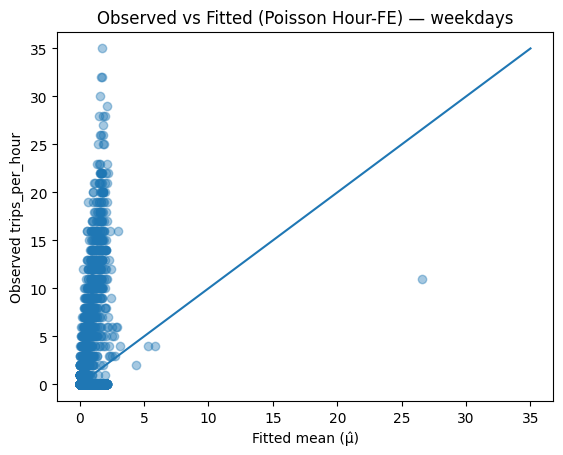

In [18]:
mu_hat = res_plot.fittedvalues  # predicted mean (Poisson)
y_obs = y_plot.values

plt.figure()
plt.scatter(mu_hat, y_obs, alpha=0.4)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Observed trips_per_hour")
plt.title(f"Observed vs Fitted (Poisson Hour-FE) — {STEP8_MODE}")

# 45-degree reference line
mx = max(mu_hat.max(), y_obs.max())
plt.plot([0, mx], [0, mx])
plt.show()


#### STEP 8.2 — Pearson residuals vs fitted

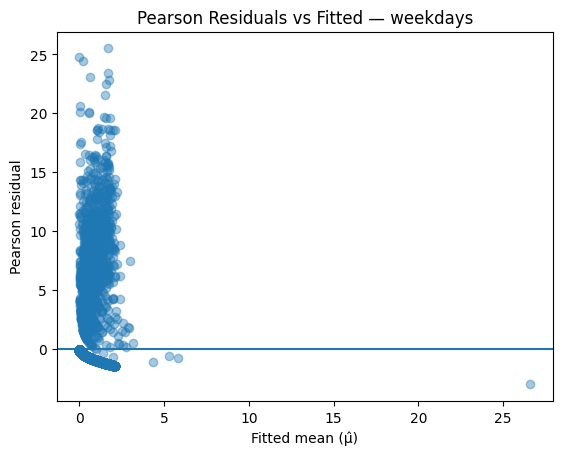

In [19]:
mu_hat = res_plot.fittedvalues
pearson_resid = res_plot.resid_pearson

plt.figure()
plt.scatter(mu_hat, pearson_resid, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Pearson residual")
plt.title(f"Pearson Residuals vs Fitted — {STEP8_MODE}")
plt.show()


#### STEP 8.4 — Compare distributions: Weekdays vs Weekends (hist + ECDF + KS test)

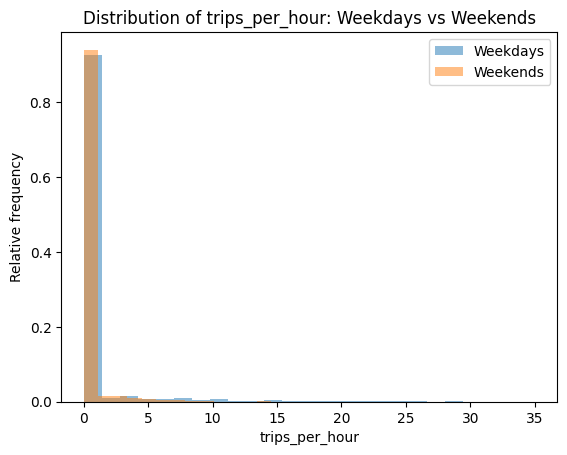

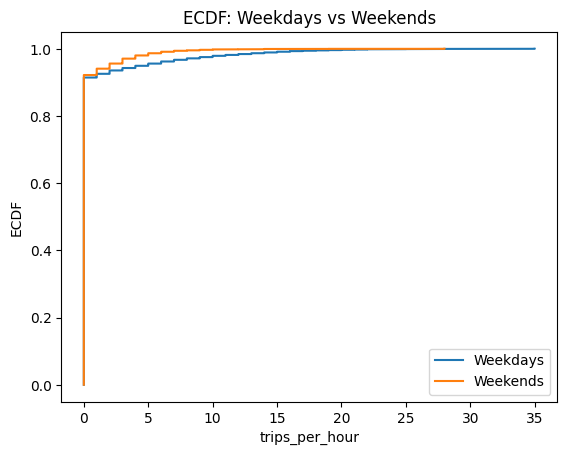

KS test Weekdays vs Weekends:
  statistic: 0.0307961364329169
  p-value: 0.0017295350640868493


In [20]:
df_wd = subset_by_mode(reg_hourly, "weekdays").copy()
df_we = subset_by_mode(reg_hourly, "weekends").copy()

y_wd = df_wd["trips_per_hour"].values
y_we = df_we["trips_per_hour"].values

# Histogram (density-ish via weights)
plt.figure()
plt.hist(y_wd, bins=25, alpha=0.5, weights=np.ones_like(y_wd)/len(y_wd), label="Weekdays")
plt.hist(y_we, bins=25, alpha=0.5, weights=np.ones_like(y_we)/len(y_we), label="Weekends")
plt.xlabel("trips_per_hour")
plt.ylabel("Relative frequency")
plt.title("Distribution of trips_per_hour: Weekdays vs Weekends")
plt.legend()
plt.show()

# ECDF
def ecdf(a):
    a = np.sort(a)
    y = np.arange(1, len(a)+1) / len(a)
    return a, y

x1, y1 = ecdf(y_wd)
x2, y2 = ecdf(y_we)

plt.figure()
plt.step(x1, y1, where="post", label="Weekdays")
plt.step(x2, y2, where="post", label="Weekends")
plt.xlabel("trips_per_hour")
plt.ylabel("ECDF")
plt.title("ECDF: Weekdays vs Weekends")
plt.legend()
plt.show()

# KS test
ks = stats.ks_2samp(y_wd, y_we, alternative="two-sided", mode="auto")
print("KS test Weekdays vs Weekends:")
print("  statistic:", ks.statistic)
print("  p-value:", ks.pvalue)



#### STEP 8.5 — “Active hours” diagnostic (fixes your hour_true KeyError) overdispersion checking

Active-hours sample size: 5962
Zero rate in active hours (%): 88.76216034887622
Active-hours dispersion: 10.868


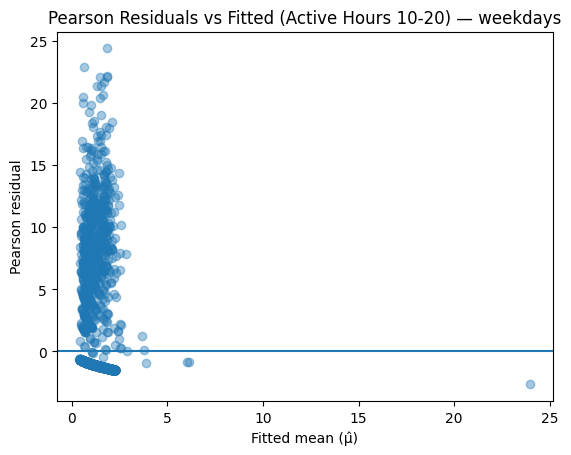

In [21]:
df_active = df_plot.copy()
df_active["hour"] = df_active["datetime_hour"].dt.hour

ACTIVE_START = 10
ACTIVE_END = 20

reg_active = df_active[df_active["hour"].between(ACTIVE_START, ACTIVE_END)].copy()

print("Active-hours sample size:", reg_active.shape[0])
print("Zero rate in active hours (%):", (reg_active["trips_per_hour"] == 0).mean() * 100)

# Fit Poisson on active hours (same spec)
res_active, X_active, y_active, reg_active = fit_poisson_hourFE(reg_active, robust=True)
print("Active-hours dispersion:", round(dispersion(res_active), 3))

# Plot residuals vs fitted in active hours
mu_hat = res_active.fittedvalues
pearson_resid = res_active.resid_pearson

plt.figure()
plt.scatter(mu_hat, pearson_resid, alpha=0.4)
plt.axhline(0)
plt.xlabel("Fitted mean (μ̂)")
plt.ylabel("Pearson residual")
plt.title(f"Pearson Residuals vs Fitted (Active Hours {ACTIVE_START}-{ACTIVE_END}) — {STEP8_MODE}")
plt.show()


#### STEP 8.6 – KS test: Friday vs Saturday

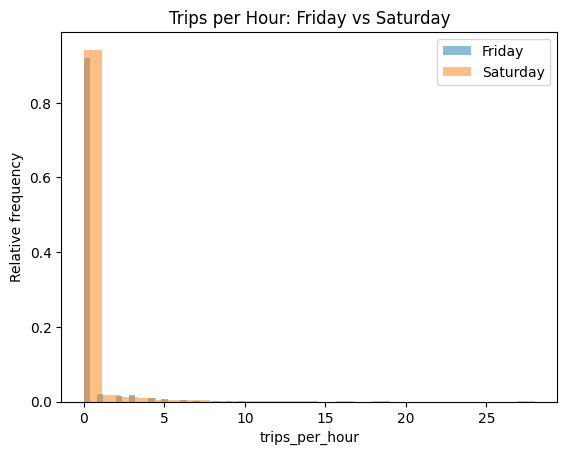

KS test Friday vs Saturday
Statistic: 0.005383231444582518
p-value: 0.9999999999993917


In [22]:
# =========================================================
# STEP 8.6 – KS test: Friday vs Saturday
# =========================================================

df_fri = reg_hourly[reg_hourly["weekday"] == 5]["trips_per_hour"].values
df_sat = reg_hourly[reg_hourly["weekday"] == 6]["trips_per_hour"].values

# Histograms
plt.figure()
plt.hist(df_fri, bins=25, alpha=0.5, weights=np.ones_like(df_fri)/len(df_fri), label="Friday")
plt.hist(df_sat, bins=25, alpha=0.5, weights=np.ones_like(df_sat)/len(df_sat), label="Saturday")
plt.xlabel("trips_per_hour")
plt.ylabel("Relative frequency")
plt.title("Trips per Hour: Friday vs Saturday")
plt.legend()
plt.show()

# KS test
ks_fs = stats.ks_2samp(df_fri, df_sat)
print("KS test Friday vs Saturday")
print("Statistic:", ks_fs.statistic)
print("p-value:", ks_fs.pvalue)


# New Models

## Modular Model

### Loading

In [23]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

from scipy.stats import norm
from IPython.display import display

In [24]:
# Load your datasets (edit paths as needed)
events_df = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Assign to Parking Lots Data\merged_parking_data_2023_2025.csv")     # scooter events dataset
weather_df = pd.read_csv(r"C:\Users\etaiw\Desktop\Projects\aviya_project\Data\Clean Data\Final Weather\merged_weather_data_2023_2025.csv")

### pre-process: 

#### Parse datetimes + create hourly keys

In [25]:
# ----------------------------
# Parse datetimes
# ----------------------------
events_df["start_time"] = pd.to_datetime(events_df["start_time"], errors="coerce")
weather_df["datetime"] = pd.to_datetime(weather_df["datetime"], errors="coerce")

# Drop rows with missing timestamps (critical)
events_df = events_df.dropna(subset=["start_time"]).copy()
weather_df = weather_df.dropna(subset=["datetime"]).copy()

# ----------------------------
# Create hourly keys
# ----------------------------
events_df["datetime_hour"] = events_df["start_time"].dt.floor("H")
weather_df["datetime_hour"] = weather_df["datetime"].dt.floor("H")


C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\3433623227.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  events_df["datetime_hour"] = events_df["start_time"].dt.floor("H")
C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\3433623227.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_df["datetime_hour"] = weather_df["datetime"].dt.floor("H")


#### Build base_df at hourly grain

In [26]:
# ----------------------------
# 1) Define which event_types count as "trips"
#    Your sample shows 'trip_end', so by default we count both start/end.
#    Change this list if you want a specific definition.
# ----------------------------
TRIP_EVENTS = ["trip_start", "trip_end"]

# ----------------------------
# 2) Create hourly weather backbone (one row per hour)
# ----------------------------
weather_keep_cols = [
    "datetime_hour",
    "temp_c", "temp_max_c", "temp_min_c",
    "wind_direction_deg", "wind_speed_ms", "rain_mm",
    "year", "day_name", "weekend", "day_of_the_month", "day_or_night", "hour"
]

weather_hourly = (
    weather_df.sort_values("datetime_hour")
              .drop_duplicates("datetime_hour")[weather_keep_cols]
              .copy()
)

# ----------------------------
# 3) Compute trips_per_hour from events (hourly counts)
# ----------------------------
trips_only = events_df[events_df["event_types"].isin(TRIP_EVENTS)].copy()

hourly_counts = (
    trips_only.groupby("datetime_hour", as_index=False)
              .agg(trips_per_hour=("event_types", "size"))
)

# ----------------------------
# 4) Merge counts into weather backbone (keep all hours)
# ----------------------------
base_df = weather_hourly.merge(hourly_counts, on="datetime_hour", how="left", validate="1:1")

# Hours with no trips become 0
base_df["trips_per_hour"] = base_df["trips_per_hour"].fillna(0).astype(int)

# ----------------------------
# 5) Ensure numeric dtypes for model variables
# ----------------------------
numeric_cols = [
    "weekend", "hour", "day_of_the_month", "day_or_night", "year",
    "rain_mm", "temp_c", "temp_max_c", "temp_min_c",
    "wind_speed_ms", "wind_direction_deg"
]
for c in numeric_cols:
    base_df[c] = pd.to_numeric(base_df[c], errors="coerce")

# Optional quick check
# display(base_df.head())
# print("Hours:", len(base_df), "| Trips sum:", base_df["trips_per_hour"].sum())


#### Global axis settings

In [27]:
# Global axis settings (fixed range for Observed vs Predicted across models)
GLOBAL_AXIS_MAX = base_df["trips_per_hour"].max()
print("GLOBAL_AXIS_MAX =", GLOBAL_AXIS_MAX)

GLOBAL_AXIS_MAX = 50


### Fit Poisson GLM + Dispersion + Coef table

In [28]:
def fit_poisson_glm(df: pd.DataFrame, formula: str, cov_type: str = "HC0"):
    """
    Fit Poisson GLM and return (results, dispersion).
    Dispersion = Pearson Chi2 / df_resid.
    """
    model = smf.glm(formula=formula, data=df, family=sm.families.Poisson())
    results = model.fit(cov_type=cov_type)

    dispersion = results.pearson_chi2 / results.df_resid if results.df_resid > 0 else np.nan
    return results, dispersion


def coef_table(results) -> pd.DataFrame:
    """
    Return a clean coefficient table: coef, std_err, z, p_value, CI.
    """
    ci = results.conf_int()
    tbl = pd.DataFrame({
        "coef": results.params,
        "std_err": results.bse,
        "z": results.tvalues,
        "p_value": results.pvalues,
        "ci_low": ci[0],
        "ci_high": ci[1],
    })
    tbl.index.name = "term"
    return tbl


### Scatter + Residuals plots

In [29]:
'''
def plot_diagnostics(df: pd.DataFrame, results, y_col: str = "trips_per_hour",
                     mode: str = "key",
                     extra_resid_vs=None,
                     axis_max: float | None = None):

    # 1) Observed vs Predicted
    plt.figure()
    plt.scatter(mu_hat, df[y_col], alpha=0.6)

    if axis_max is None:
        # Auto range (diagnostic view)
        mn = min(mu_hat.min(), df[y_col].min())
        mx = max(mu_hat.max(), df[y_col].max())
        plt.plot([mn, mx], [mn, mx], linestyle="--")
    else:
        # Fixed range (comparison view)
        plt.plot([0, axis_max], [0, axis_max], linestyle="--")
        plt.xlim(0, axis_max)
        plt.ylim(0, axis_max)

    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel(f"Observed ({y_col})")
    plt.title("Observed vs Predicted (Scatter)")
    plt.show()

    # 2) Residuals vs Fitted (Pearson)
    plt.figure()
    plt.scatter(mu_hat, resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Fitted (Pearson)")
    plt.show()

    # 3) Residuals vs Index
    plt.figure()
    plt.scatter(np.arange(len(resid_pearson)), resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Row index")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Index")
    plt.show()

    # Stop here if key mode
    if mode == "key":
        return

    # 4) QQ plot (Deviance residuals)
    plt.figure()
    sm.qqplot(resid_deviance, line="45", fit=True)
    plt.title("QQ Plot — Deviance residuals")
    plt.show()

    # 5) Residuals vs predictors (optional)
    if extra_resid_vs:
        for x in extra_resid_vs:
            if x in df.columns:
                plt.figure()
                plt.scatter(df[x], resid_pearson, alpha=0.6)
                plt.axhline(0)
                plt.xlabel(x)
                plt.ylabel("Pearson residuals")
                plt.title(f"Residuals vs {x}")
                plt.show()
'''
# new version
def plot_diagnostics(df: pd.DataFrame, results, y_col: str = "trips_per_hour",
                     mode: str = "key",
                     extra_resid_vs=None,
                     axis_max: float | None = None):

    # Extract fitted values and residuals from results
    mu_hat = results.fittedvalues  # predicted mean (Poisson)
    resid_pearson = results.resid_pearson

    # 1) Observed vs Predicted
    plt.figure()
    plt.scatter(mu_hat, df[y_col], alpha=0.6)

    if axis_max is None:
        # Auto range (diagnostic view)
        mn = min(mu_hat.min(), df[y_col].min())
        mx = max(mu_hat.max(), df[y_col].max())
        plt.plot([mn, mx], [mn, mx], linestyle="--")
    else:
        # Fixed range (comparison view)
        plt.plot([0, axis_max], [0, axis_max], linestyle="--")
        plt.xlim(0, axis_max)
        plt.ylim(0, axis_max)

    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel(f"Observed ({y_col})")
    plt.title("Observed vs Predicted (Scatter)")
    plt.show()

    # 2) Residuals vs Fitted (Pearson)
    plt.figure()
    plt.scatter(mu_hat, resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Predicted mean (mu_hat)")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Fitted (Pearson)")
    plt.show()

    # 3) Residuals vs Index
    plt.figure()
    plt.scatter(np.arange(len(resid_pearson)), resid_pearson, alpha=0.6)
    plt.axhline(0)
    plt.xlabel("Row index")
    plt.ylabel("Pearson residuals")
    plt.title("Residuals vs Index")
    plt.show()

    # Stop here if key mode
    if mode == "key":
        return

    # 4) QQ plot (Deviance residuals)
    plt.figure()
    sm.qqplot(resid_deviance, line="45", fit=True)
    plt.title("QQ Plot — Deviance residuals")
    plt.show()

    # 5) Residuals vs predictors (optional)
    if extra_resid_vs:
        for x in extra_resid_vs:
            if x in df.columns:
                plt.figure()
                plt.scatter(df[x], resid_pearson, alpha=0.6)
                plt.axhline(0)
                plt.xlabel(x)
                plt.ylabel("Pearson residuals")
                plt.title(f"Residuals vs {x}")
                plt.show()

### Segmentation helpers

In [30]:
def add_binned_feature(df: pd.DataFrame, var: str, out_col: str,
                      method: str = "quantile", q: int = 4,
                      edges=None, labels=None, include_lowest: bool = True):
    """
    Create a categorical (binned) version of a continuous variable.

    method:
      - 'quantile': qcut into q bins (data-driven segmentation)
      - 'cut': cut using explicit edges (domain-driven segmentation)
    """
    if method == "quantile":
        df[out_col] = pd.qcut(df[var], q=q, duplicates="drop")
    elif method == "cut":
        if edges is None:
            raise ValueError("edges must be provided for method='cut'")
        df[out_col] = pd.cut(df[var], bins=edges, labels=labels, include_lowest=include_lowest)
    else:
        raise ValueError("method must be 'quantile' or 'cut'")

    df[out_col] = df[out_col].astype("category")
    return df


def add_hour_segments(df: pd.DataFrame, hour_col: str = "hour", out_col: str = "hour_segment",
                      edges=None, labels=None):
    """
    Create categorical hour segments (e.g., night/morning/afternoon/evening/late).
    """
    if edges is None:
        edges = [-0.1, 5, 11, 16, 21, 23.1]
        labels = ["night", "morning", "afternoon", "evening", "late"]

    df[out_col] = pd.cut(df[hour_col], bins=edges, labels=labels, include_lowest=True)
    df[out_col] = df[out_col].astype("category")
    return df


def add_rain_segments(df: pd.DataFrame, rain_col: str = "rain_mm", out_col: str = "rain_segment",
                      edges=None, labels=None):
    """
    Create categorical rain segments (e.g., 0, 0-1, 1-3, 3+).
    """
    if edges is None:
        edges = [-0.001, 0, 1, 3, np.inf]
        labels = ["0", "0-1", "1-3", "3+"]

    df[out_col] = pd.cut(df[rain_col], bins=edges, labels=labels, include_lowest=True)
    df[out_col] = df[out_col].astype("category")
    return df


### Post-hoc

In [31]:
def posthoc_pairwise_wald(results, factor_col: str, correction: str = "holm") -> pd.DataFrame:
    """
    Post-hoc pairwise comparisons for a categorical factor in a GLM using Wald contrasts.
    Designed for terms like C(factor_col) in the formula.

    Returns pairwise comparisons on:
      - log scale (effect_log)
      - IRR = exp(effect_log)
      - adjusted p-values (multiplicity correction)
    """
    params = results.params
    cov = results.cov_params()

    df_used = results.model.data.frame
    if factor_col not in df_used.columns:
        raise ValueError(f"{factor_col} not found in the model dataframe.")

    if not pd.api.types.is_categorical_dtype(df_used[factor_col]):
        raise ValueError(f"{factor_col} must be categorical (dtype 'category') for post-hoc.")

    levels = list(df_used[factor_col].cat.categories)
    if len(levels) < 2:
        raise ValueError(f"{factor_col} must have at least 2 levels.")

    baseline = levels[0]

    prefix = f"C({factor_col})[T."
    level_to_param = {baseline: None}
    for lvl in levels[1:]:
        level_to_param[lvl] = f"C({factor_col})[T.{lvl}]"

    idx = {p: k for k, p in enumerate(params.index)}

    rows = []

    for i in range(len(levels)):
        for j in range(i + 1, len(levels)):
            li, lj = levels[i], levels[j]
            pi, pj = level_to_param[li], level_to_param[lj]

            c = np.zeros(len(params))
            if pi is not None:
                c[idx[pi]] += 1.0
            if pj is not None:
                c[idx[pj]] -= 1.0

            est = float(c @ params.values)
            var = float(c @ cov.values @ c)
            se = np.sqrt(var) if var >= 0 else np.nan
            z = est / se if (np.isfinite(se) and se > 0) else np.nan
            p = 2 * norm.sf(abs(z)) if np.isfinite(z) else np.nan

            ci_low = est - 1.96 * se if np.isfinite(se) else np.nan
            ci_high = est + 1.96 * se if np.isfinite(se) else np.nan

            rows.append({
                "level_i": li,
                "level_j": lj,
                "effect_log": est,
                "se": se,
                "z": z,
                "p_raw": p,
                "IRR": np.exp(est) if np.isfinite(est) else np.nan,
                "IRR_ci_low": np.exp(ci_low) if np.isfinite(ci_low) else np.nan,
                "IRR_ci_high": np.exp(ci_high) if np.isfinite(ci_high) else np.nan,
            })

    out = pd.DataFrame(rows)

    if len(out) > 0 and out["p_raw"].notna().any():
        reject, p_adj, _, _ = multipletests(out["p_raw"].values, method=correction)
        out["p_adj"] = p_adj
        out["reject_0.05"] = reject
    else:
        out["p_adj"] = np.nan
        out["reject_0.05"] = False

    return out.sort_values(["p_adj", "p_raw"])


### Build per-model dataset

In [32]:
def build_model_dataset(base_df: pd.DataFrame, spec: dict) -> pd.DataFrame:
    """
    Build a model-specific dataset:
      1) Apply filters (weekday/weekend/no-rain)
      2) Add model-specific engineered features (hour FE, segmentations, generic bins)
    """
    df = base_df.copy()

    # ----------------------------
    # 1) Filters
    # ----------------------------
    mask = pd.Series(True, index=df.index)

    if spec.get("weekday_only", False):
        mask &= (df["weekend"] == 0)

    if spec.get("weekend_only", False):
        mask &= (df["weekend"] == 1)

    if spec.get("no_rain_only", False):
        mask &= (df["rain_mm"].fillna(np.nan) == 0)

    df = df.loc[mask].copy()

    # ----------------------------
    # 2) Core categorical encodings
    # ----------------------------
    if spec.get("hour_fe", False):
        df["hour_cat"] = df["hour"].astype(int).astype("category")

    if spec.get("dow_fe", False):
        df["day_name_cat"] = df["day_name"].astype("category")

    # ----------------------------
    # 3) Optional segmentations: hour and rain
    # ----------------------------
    if spec.get("hour_seg", None) is not None:
        hs = spec["hour_seg"]
        df = add_hour_segments(
            df=df,
            hour_col=hs.get("hour_col", "hour"),
            out_col=hs.get("out_col", "hour_segment"),
            edges=hs.get("edges", None),
            labels=hs.get("labels", None),
        )

    if spec.get("rain_seg", None) is not None:
        rs = spec["rain_seg"]
        df = add_rain_segments(
            df=df,
            rain_col=rs.get("rain_col", "rain_mm"),
            out_col=rs.get("out_col", "rain_segment"),
            edges=rs.get("edges", None),
            labels=rs.get("labels", None),
        )

    # ----------------------------
    # 4) Optional generic binning for continuous vars
    # ----------------------------
    for b in spec.get("bins", []):
        df = add_binned_feature(
            df=df,
            var=b["var"],
            out_col=b["out_col"],
            method=b.get("method", "quantile"),
            q=b.get("q", 4),
            edges=b.get("edges", None),
            labels=b.get("labels", None),
            include_lowest=b.get("include_lowest", True),
        )

    return df


### Formula builder + runner

In [33]:
def build_formula(y: str, terms: list[str]) -> str:
    """
    Build a statsmodels formula like: y ~ term1 + term2 + ...
    """
    return f"{y} ~ 1" if not terms else f"{y} ~ " + " + ".join(terms)


def run_poisson_model(base_df: pd.DataFrame, spec: dict, y_col: str = "trips_per_hour"):
    """
    End-to-end runner:
      - Build model dataset
      - Build formula
      - Fit Poisson GLM (robust SE by default)
      - Print summary + dispersion
      - Display coefficient table
      - Plot diagnostics
      - Optional: post-hoc for a categorical factor (if defined in spec)
    """
    df_model = build_model_dataset(base_df, spec)
    formula = build_formula(y=y_col, terms=spec["terms"])

    results, dispersion = fit_poisson_glm(
        df=df_model,
        formula=formula,
        cov_type=spec.get("cov_type", "HC0")
    )

    print("\n" + "=" * 120)
    print(f"MODEL: {spec.get('name', 'Unnamed')}")
    print(f"Formula: {formula}")
    print(f"N rows: {len(df_model)}")
    print(f"Dispersion (Pearson Chi2 / df_resid): {dispersion:.4f}")
    print("=" * 120 + "\n")

    print(results.summary())

    tbl = coef_table(results)
    display(tbl)


    if spec.get("plots", True):
        df_used = results.model.data.frame
        plot_diagnostics(
            df=df_used,
            results=results,
            y_col=y_col,
            mode=spec.get("plots_mode", "key"),
            extra_resid_vs=spec.get("resid_vs_predictors", None),
            axis_max=spec.get("axis_max", None),
        )


    posthoc_out = None
    if spec.get("posthoc", None) is not None:
        ph = spec["posthoc"]
        posthoc_out = posthoc_pairwise_wald(
            results=results,
            factor_col=ph["factor_col"],
            correction=ph.get("correction", "holm")
        )
        display(posthoc_out)

    return {
        "name": spec.get("name", "Unnamed"),
        "df": df_model,
        "formula": formula,
        "results": results,
        "dispersion": dispersion,
        "coef_table": tbl,
        "posthoc": posthoc_out
    }


### GLOBAL_AXIS_MAX

In [34]:
GLOBAL_AXIS_MAX = base_df["trips_per_hour"].max()
print("GLOBAL_AXIS_MAX =", GLOBAL_AXIS_MAX)

GLOBAL_AXIS_MAX = 50


## Models

### Model 0 - including weekeneds, all hours, with rain days


MODEL: Model 0 — Baseline (All days incl. weekend) — Hour FE
Formula: trips_per_hour ~ C(hour_cat)
N rows: 1994
Dispersion (Pearson Chi2 / df_resid): 4.0457

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1994
Model:                            GLM   Df Residuals:                     1970
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7452.8
Date:                Tue, 13 Jan 2026   Deviance:                       8459.8
Time:                        03:25:56   Pearson chi2:                 7.97e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9958
Covariance Type:                  HC0                                         
                        coef    std err          z 

,coef,std_err,z,p_value,ci_low,ci_high
term,,,,,,
Intercept,1.344246,0.101352,13.263126,3.787695e-40,1.145600,1.542893
C(hour_cat)[T.1],-0.351441,0.160521,-2.189370,2.856995e-02,-0.666057,-0.036825
C(hour_cat)[T.2],-0.872738,0.194268,-4.492436,7.041306e-06,-1.253496,-0.491979
C(hour_cat)[T.3],-1.393639,0.210262,-6.628093,3.400506e-11,-1.805746,-0.981532
C(hour_cat)[T.4],-1.912939,0.213909,-8.942788,3.794730e-19,-2.332192,-1.493686
C(hour_cat)[T.5],-2.329100,0.287248,-8.108330,5.132008e-16,-2.892095,-1.766104
C(hour_cat)[T.6],-1.500407,0.172527,-8.696670,3.417641e-18,-1.838553,-1.162261
C(hour_cat)[T.7],-0.290816,0.134020,-2.169945,3.001103e-02,-0.553490,-0.028142
C(hour_cat)[T.8],1.042636,0.122843,8.487536,2.110643e-17,0.801868,1.283404


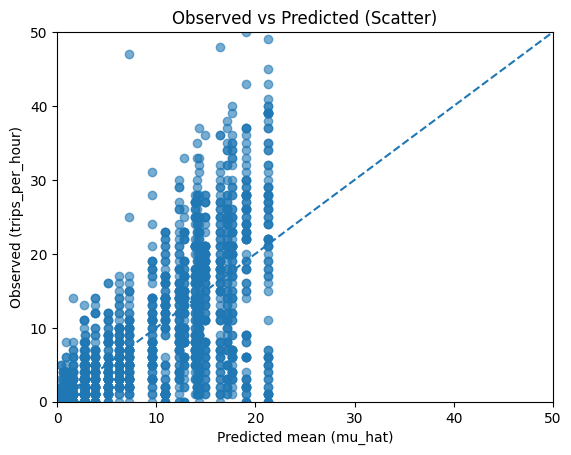

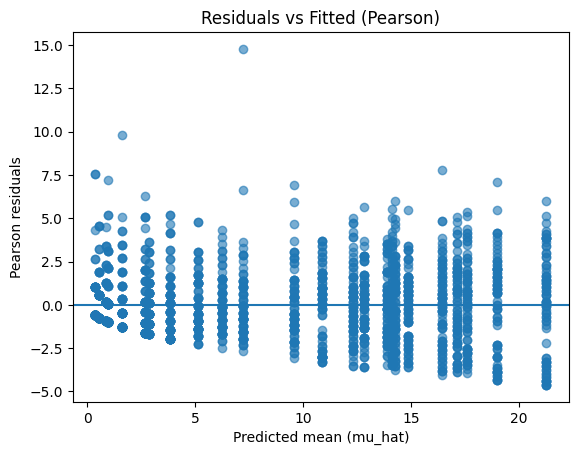

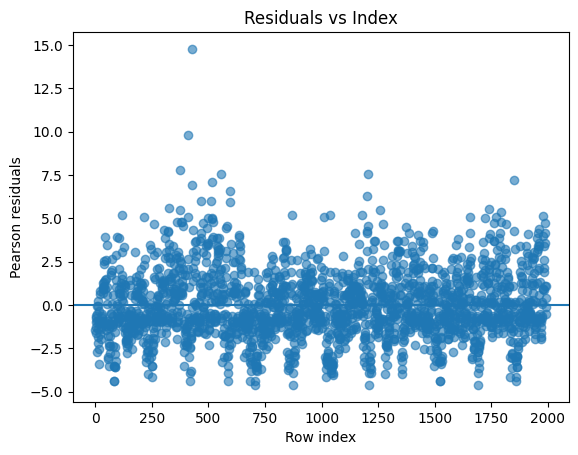

In [35]:
model0_spec = {
    "name": "Model 0 — Baseline (All days incl. weekend) — Hour FE",
    "weekday_only": False,
    "weekend_only": False,
    "no_rain_only": False,

    "hour_fe": True,
    "dow_fe": False,
    "cov_type": "HC0",

    "hour_seg": None,
    "rain_seg": None,
    "bins": [],

    "terms": [
        "C(hour_cat)"
    ],

    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,

    "posthoc": None
}

out_model0 = run_poisson_model(base_df, model0_spec)


### Model 1 - Only work-days and withought rain days - Baselins


MODEL: Model 1 — Routine (Weekdays only + No Rain) — Hour FE
Formula: trips_per_hour ~ C(hour_cat)
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.1495

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1292
Model Family:                 Poisson   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3655.3
Date:                Tue, 13 Jan 2026   Deviance:                       2786.6
Time:                        03:25:57   Pearson chi2:                 2.78e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                                         
                        coef    std err          z 

,coef,std_err,z,p_value,ci_low,ci_high
term,,,,,,
Intercept,1.087249,0.133760,8.128370,4.351014e-16,0.825084,1.349413
C(hour_cat)[T.1],-0.554444,0.207576,-2.671044,7.561576e-03,-0.961285,-0.147603
C(hour_cat)[T.2],-1.273351,0.246996,-5.155342,2.531684e-07,-1.757455,-0.789247
C(hour_cat)[T.3],-2.226683,0.302724,-7.355494,1.902216e-13,-2.820010,-1.633355
C(hour_cat)[T.4],-2.349490,0.288909,-8.132296,4.212356e-16,-2.915741,-1.783240
C(hour_cat)[T.5],-2.678337,0.326820,-8.195151,2.502791e-16,-3.318892,-2.037782
C(hour_cat)[T.6],-1.068899,0.211335,-5.057848,4.240137e-07,-1.483108,-0.654691
C(hour_cat)[T.7],0.251644,0.155900,1.614135,1.064982e-01,-0.053915,0.557202
C(hour_cat)[T.8],1.610688,0.139866,11.515969,1.096206e-30,1.336556,1.884819


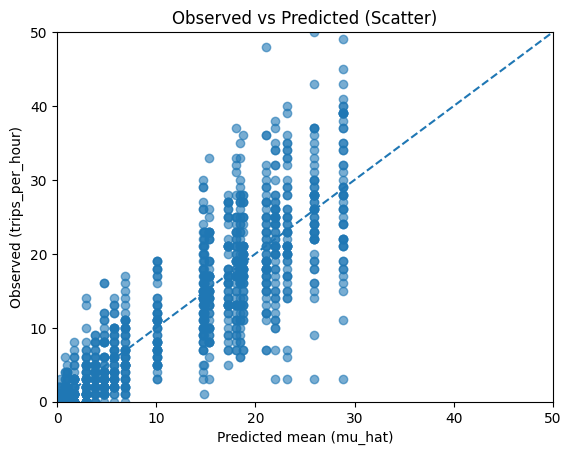

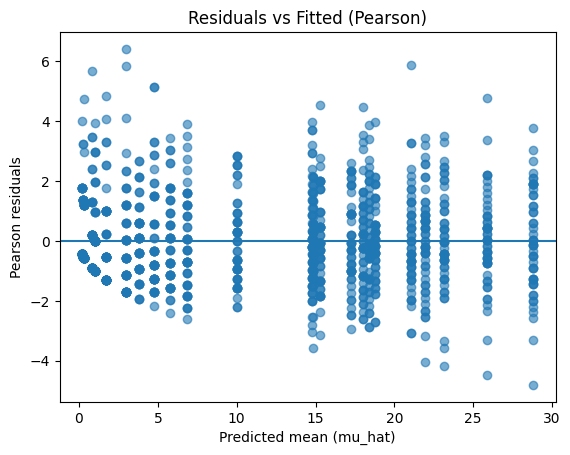

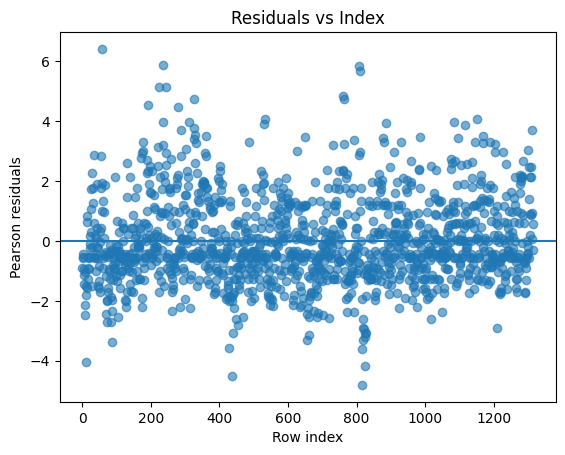

In [36]:
model1_spec = {
    "name": "Model 1 — Routine (Weekdays only + No Rain) — Hour FE",
    "weekday_only": True,
    "weekend_only": False,
    "no_rain_only": True,

    "hour_fe": True,
    "dow_fe": False,
    "cov_type": "HC0",

    "hour_seg": None,
    "rain_seg": None,
    "bins": [],

    "terms": ["C(hour_cat)"],

    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,  # ✅ fixed axis (same as Model 0)

    "posthoc": None
}

out_model1 = run_poisson_model(base_df, model1_spec)


### Model 2 - Only work-days without rain continous hourly without rain variable


MODEL: Model 2 — Routine Baseline (Weekdays, No-Rain): Hour-of-Day Effects & Post-hoc Segmentation
Formula: trips_per_hour ~ C(hour_cat) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.0962

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1290
Model Family:                 Poisson   Df Model:                           25
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3619.3
Date:                Tue, 13 Jan 2026   Deviance:                       2714.6
Time:                        03:26:20   Pearson chi2:                 2.70e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9998
Covariance Type:                  HC0                              

,coef,std_err,z,p_value,ci_low,ci_high
term,,,,,,
Intercept,0.819426,0.144498,5.670857,1.420851e-08,0.536216,1.102636
C(hour_cat)[T.1],-0.543688,0.205561,-2.644894,8.171642e-03,-0.946581,-0.140795
C(hour_cat)[T.2],-1.260914,0.244881,-5.149088,2.617567e-07,-1.740873,-0.780956
C(hour_cat)[T.3],-2.206854,0.299470,-7.369192,1.716653e-13,-2.793805,-1.619903
C(hour_cat)[T.4],-2.320030,0.286489,-8.098143,5.580454e-16,-2.881539,-1.758522
C(hour_cat)[T.5],-2.642023,0.323628,-8.163754,3.247698e-16,-3.276323,-2.007723
C(hour_cat)[T.6],-1.030386,0.208985,-4.930428,8.204948e-07,-1.439990,-0.620783
C(hour_cat)[T.7],0.287983,0.154157,1.868115,6.174599e-02,-0.014159,0.590124
C(hour_cat)[T.8],1.623726,0.136990,11.852904,2.078601e-32,1.355231,1.892221


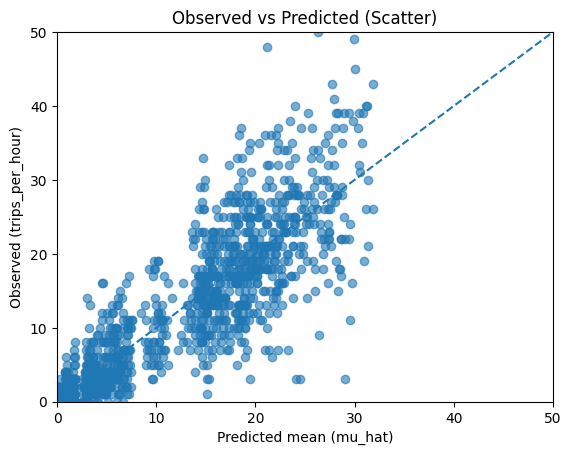

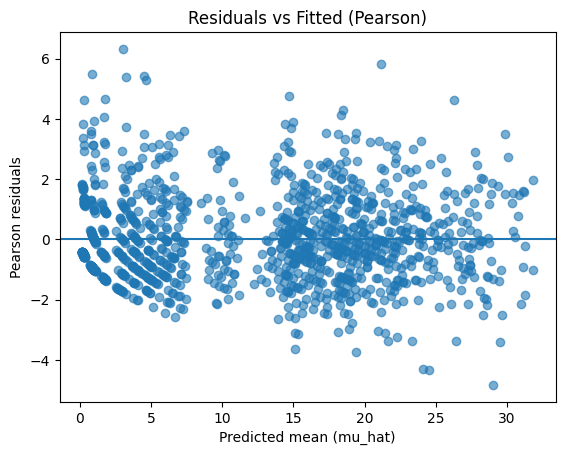

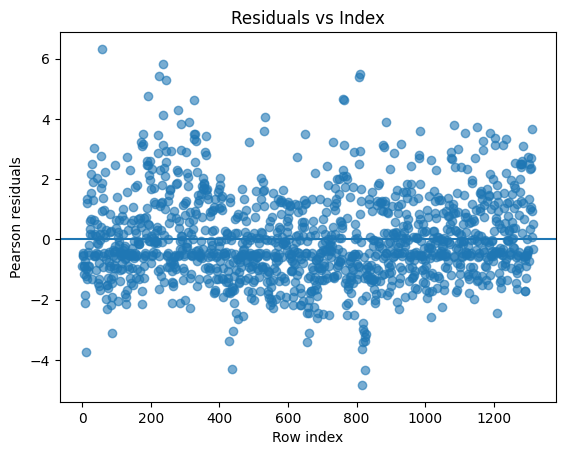

C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


,level_i,level_j,effect_log,se,z,p_raw,IRR,IRR_ci_low,IRR_ci_high,p_adj,reject_0.05
141,7,9,-1.967993,0.092782,-21.210908,7.573633e-100,0.139737,0.116502,0.167606,2.090323e-97,True
142,7,10,-1.843649,0.092352,-19.963300,1.148697e-88,0.158239,0.132039,0.189638,3.158917e-86,True
125,6,9,-3.286362,0.168830,-19.465498,2.153896e-84,0.037390,0.026856,0.052055,5.901675e-82,True
126,6,10,-3.162018,0.168461,-18.770075,1.326983e-78,0.042340,0.030434,0.058905,3.622664e-76,True
150,7,18,-1.724504,0.095885,-17.985075,2.550421e-72,0.178261,0.147720,0.215118,6.937146e-70,True
...,...,...,...,...,...,...,...,...,...,...,...
161,8,14,0.036849,0.067641,0.544769,5.859126e-01,1.037536,0.908711,1.184624,1.000000e+00,False
198,11,12,0.025576,0.065370,0.391249,6.956135e-01,1.025906,0.902534,1.166141,1.000000e+00,False
66,3,4,0.113177,0.370928,0.305118,7.602765e-01,1.119830,0.541267,2.316818,1.000000e+00,False
235,14,19,0.020814,0.076039,0.273725,7.842959e-01,1.021032,0.879657,1.185128,1.000000e+00,False


In [49]:
model2_spec = {
    "name": "Model 2 — Routine Baseline (Weekdays, No-Rain): Hour-of-Day Effects & Post-hoc Segmentation",

    # Filters (same routine definition)
    "weekday_only": True,     # Sun–Thu (weekend==0)
    "no_rain_only": True,     # rain_mm == 0

    # Build hour categorical (24 levels)
    "hour_fe": True,

    # IMPORTANT: no rain_mm in the model terms
    "terms": [
        "C(hour_cat)",
        "temp_c",
        "wind_speed_ms",
        # אפשר להוסיף עוד משתנים אם יש לך, כל עוד הם לא גשם
    ],

    "cov_type": "HC0",
    "plots": True,
    "plots_mode": "key",
    "axis_max": GLOBAL_AXIS_MAX,

    # Post hoc on 24-hour factor (for segmentation)
    "posthoc": {
        "factor_col": "hour_cat",
        "correction": "holm"
    }
}

out_model2 = run_poisson_model(base_df, model2_spec, y_col="trips_per_hour")


## Post Hoc and Segments Analysis

#### Step 1: Analyze Model 2 Post-hoc Results for Segmentation

In [38]:
# =================================================
# STEP 1: ANALYZE POST-HOC RESULTS FOR SEGMENTATION
# =================================================

print("ANALYZING MODEL 2 POST-HOC RESULTS FOR SEGMENTATION")
print("=" * 60)

# Get the post-hoc results from Model 2
posthoc_results = out_model2["posthoc"]

# Sort by most significant differences (lowest p_adj)
most_significant = posthoc_results.sort_values('p_adj').head(15)
print("Most significant hour differences:")
print(most_significant[['level_i', 'level_j', 'IRR', 'p_adj', 'reject_0.05']].to_string())

# Look for extreme IRR values (< 0.5 or > 2.0) that indicate clear boundaries
extreme_differences = posthoc_results[
    (posthoc_results['IRR'] < 0.5) | (posthoc_results['IRR'] > 2.0)
].sort_values('p_adj')

print(f"\nExtreme differences (IRR < 0.5 or > 2.0): {len(extreme_differences)} found")
if len(extreme_differences) > 0:
    print(extreme_differences[['level_i', 'level_j', 'IRR', 'p_adj']].head(10).to_string())

# Check for similar hours (IRR close to 1.0, not significant)
similar_hours = posthoc_results[
    (~posthoc_results['reject_0.05']) & 
    (posthoc_results['IRR'].between(0.8, 1.25))
]

print(f"\nSimilar hour pairs (IRR 0.8-1.25, not significant): {len(similar_hours)} found")
if len(similar_hours) > 0:
    print(similar_hours[['level_i', 'level_j', 'IRR']].head(10).to_string())

ANALYZING MODEL 2 POST-HOC RESULTS FOR SEGMENTATION
Most significant hour differences:
     level_i  level_j       IRR         p_adj  reject_0.05
141        7        9  0.139737  2.090323e-97         True
142        7       10  0.158239  3.158917e-86         True
125        6        9  0.037390  5.901675e-82         True
126        6       10  0.042340  3.622664e-76         True
150        7       18  0.178261  6.937146e-70         True
134        6       18  0.047698  5.834247e-69         True
183        9       22  5.021377  7.817712e-68         True
90         4        9  0.010296  1.253134e-67         True
133        6       17  0.050281  1.756933e-66         True
149        7       17  0.187917  3.509153e-65         True
91         4       10  0.011659  4.236886e-64         True
132        6       16  0.053047  5.405707e-63         True
30         1        9  0.060831  1.288773e-62         True
99         4       18  0.013134  4.067299e-60         True
131        6       15  0.059

#### Step 2: Identify Key Segmentation Boundaries

In [39]:
# =================================================
# STEP 2: IDENTIFY KEY SEGMENTATION BOUNDARIES
# =================================================

print("IDENTIFYING KEY SEGMENTATION BOUNDARIES")
print("=" * 60)

# Key insights from your post-hoc analysis:
boundary_candidates = [
    {"boundary": "After hour 5", "evidence": "Hour 6 vs 9: IRR=0.037, Hour 6 vs 10: IRR=0.042"},
    {"boundary": "After hour 7", "evidence": "Hour 7 vs 9: IRR=0.14, Hour 7 vs 10: IRR=0.16"}, 
    {"boundary": "After hour 8", "evidence": "Morning transition to peak hours"},
    {"boundary": "After hour 11", "evidence": "Peak morning to midday transition"},
    {"boundary": "After hour 14", "evidence": "Midday to afternoon transition"},
    {"boundary": "After hour 17", "evidence": "Afternoon to evening transition"}
]

for boundary in boundary_candidates:
    print(f"• {boundary['boundary']}: {boundary['evidence']}")

# Proposed 6-segment boundaries based on analysis
proposed_segments = {
    "boundaries": [0, 6, 9, 12, 15, 18, 24],
    "labels": ["early_morning", "morning", "peak_morning", "midday", "late_afternoon", "evening"],
    "rationale": "Separates very different hours (6 vs 9-11) while grouping similar ones"
}

print(f"\nProposed 6-segment boundaries: {proposed_segments['boundaries']}")
print(f"Labels: {proposed_segments['labels']}")
print(f"Rationale: {proposed_segments['rationale']}")

# Test with different segment counts
segment_options = {
    5: {"boundaries": [0, 7, 11, 15, 19, 24], "labels": ["early_morning", "morning", "midday", "afternoon", "evening"]},
    6: {"boundaries": [0, 6, 9, 12, 15, 18, 24], "labels": ["early_morning", "morning", "peak_morning", "midday", "late_afternoon", "evening"]},
    7: {"boundaries": [0, 6, 9, 12, 15, 17, 20, 24], "labels": ["early_morning", "morning", "peak_morning", "midday", "afternoon", "evening", "late_evening"]}
}

print(f"\nAlternative options:")
for n_seg, config in segment_options.items():
    print(f"  {n_seg} segments: {config['boundaries']} - {config['labels']}")

IDENTIFYING KEY SEGMENTATION BOUNDARIES
• After hour 5: Hour 6 vs 9: IRR=0.037, Hour 6 vs 10: IRR=0.042
• After hour 7: Hour 7 vs 9: IRR=0.14, Hour 7 vs 10: IRR=0.16
• After hour 8: Morning transition to peak hours
• After hour 11: Peak morning to midday transition
• After hour 14: Midday to afternoon transition
• After hour 17: Afternoon to evening transition

Proposed 6-segment boundaries: [0, 6, 9, 12, 15, 18, 24]
Labels: ['early_morning', 'morning', 'peak_morning', 'midday', 'late_afternoon', 'evening']
Rationale: Separates very different hours (6 vs 9-11) while grouping similar ones

Alternative options:
  5 segments: [0, 7, 11, 15, 19, 24] - ['early_morning', 'morning', 'midday', 'afternoon', 'evening']
  6 segments: [0, 6, 9, 12, 15, 18, 24] - ['early_morning', 'morning', 'peak_morning', 'midday', 'late_afternoon', 'evening']
  7 segments: [0, 6, 9, 12, 15, 17, 20, 24] - ['early_morning', 'morning', 'peak_morning', 'midday', 'afternoon', 'evening', 'late_evening']


### Create 4-Segment Daytime Segmentation

#### Step 1: Analyze Your Post-hoc Patterns

In [40]:
# Look at the post-hoc results to identify natural groupings
posthoc_results = out_model2["posthoc"]

# Sort by adjusted p-value to see most significant differences
significant_diffs = posthoc_results[posthoc_results['reject_0.05']].sort_values('p_adj')
print("Most significant hour differences:")
print(significant_diffs[['level_i', 'level_j', 'IRR', 'p_adj']].head(20))

# Look at hours that are NOT significantly different (similar hours)
non_significant = posthoc_results[~posthoc_results['reject_0.05']]
print("\nHours with similar trip patterns:")
print(non_significant[['level_i', 'level_j', 'IRR']].head(20))

Most significant hour differences:
     level_i  level_j       IRR         p_adj
141        7        9  0.139737  2.090323e-97
142        7       10  0.158239  3.158917e-86
125        6        9  0.037390  5.901675e-82
126        6       10  0.042340  3.622664e-76
150        7       18  0.178261  6.937146e-70
134        6       18  0.047698  5.834247e-69
183        9       22  5.021377  7.817712e-68
90         4        9  0.010296  1.253134e-67
133        6       17  0.050281  1.756933e-66
149        7       17  0.187917  3.509153e-65
91         4       10  0.011659  4.236886e-64
132        6       16  0.053047  5.405707e-63
30         1        9  0.060831  1.288773e-62
99         4       18  0.013134  4.067299e-60
131        6       15  0.059448  4.692469e-60
51         2        9  0.029692  1.165489e-59
196       10       22  4.434261  2.233482e-59
127        6       11  0.060185  8.248787e-59
98         4       17  0.013846  1.249929e-58
8          0        9  0.104771  8.025755e-58

#### Step 2: Define Your 4 Segments Based on Patterns


MODEL: Model 3 — 4-Segment Daytime Analysis (Weekdays, No-Rain)
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 3.9184

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1310
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4767.1
Date:                Tue, 13 Jan 2026   Deviance:                       5010.2
Time:                        03:25:57   Pearson chi2:                 5.13e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9988
Covariance Type:                  HC0                                         
                

,coef,std_err,z,p_value,ci_low,ci_high
term,,,,,,
Intercept,-0.411944,0.110250,-3.736441,1.866436e-04,-0.628030,-0.195857
C(daytime_segment)[T.morning_noon],2.706994,0.078427,34.516118,4.597280e-261,2.553280,2.860708
C(daytime_segment)[T.afternoon],2.277017,0.079084,28.792241,2.682704e-182,2.122014,2.432020
C(daytime_segment)[T.evening],2.082029,0.080288,25.932125,2.893003e-148,1.924668,2.239389
temp_c,0.056397,0.005898,9.562884,1.145200e-21,0.044838,0.067956
wind_speed_ms,0.004487,0.006048,0.741915,4.581390e-01,-0.007366,0.016340


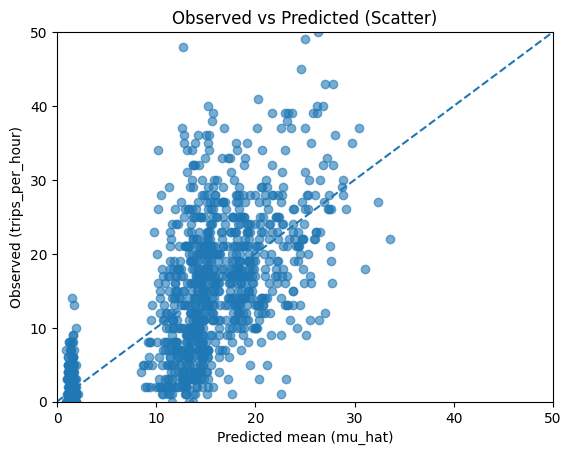

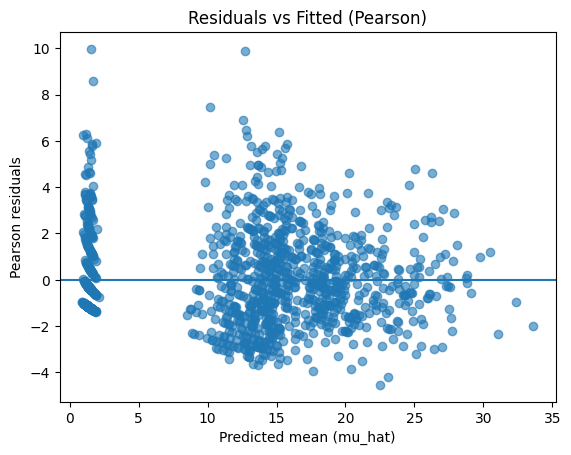

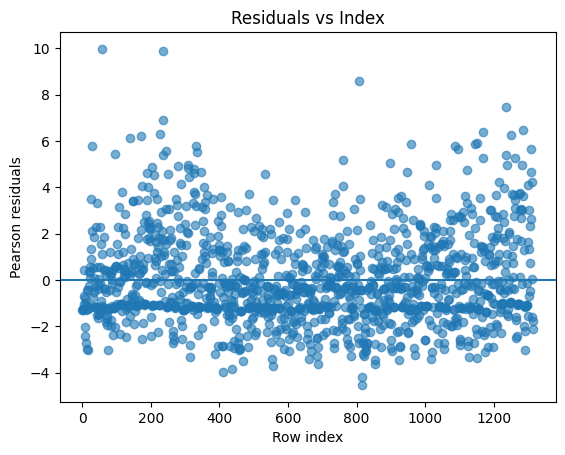

C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


,level_i,level_j,effect_log,se,z,p_raw,IRR,IRR_ci_low,IRR_ci_high,p_adj,reject_0.05
0,early_morning,morning_noon,-2.706994,0.078427,-34.516118,4.597280e-261,0.066737,0.057228,0.077826,2.758368e-260,True
1,early_morning,afternoon,-2.277017,0.079084,-28.792241,2.682704e-182,0.102590,0.087859,0.119790,1.341352e-181,True
2,early_morning,evening,-2.082029,0.080288,-25.932125,2.893003e-148,0.124677,0.106523,0.145925,1.157201e-147,True
4,morning_noon,evening,0.624966,0.044201,14.139315,2.173909e-45,1.868182,1.713148,2.037246,6.521728e-45,True
3,morning_noon,afternoon,0.429977,0.040356,10.654694,1.657888e-26,1.537223,1.420317,1.663751,3.315776e-26,True
5,afternoon,evening,0.194988,0.038474,5.068095,4.018169e-07,1.215297,1.127023,1.310485,4.018169e-07,True


In [41]:
# Create a new model spec for 4-segment analysis
model_4segment_spec = {
    "name": "Model 3 — 4-Segment Daytime Analysis (Weekdays, No-Rain)",
    
    # Same filters as Model 2
    "weekday_only": True,
    "no_rain_only": True,
    
    # Add custom hour segmentation instead of hour_fe
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 7, 10, 15, 24],  # Adjust these based on your post-hoc analysis
        #"edges": [0, 6, 12, 17, 24],  # Adjust these based on your post-hoc analysis
        "labels": ["early_morning", "morning_noon", "afternoon", "evening"]
    },
    
    # Weather variables (same as Model 2)
    "terms": [
        "C(daytime_segment)",
        "temp_c", 
        "wind_speed_ms"
    ],
    
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    # Post-hoc on the 4 segments
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}

# Run the model
out_model_4seg = run_poisson_model(base_df, model_4segment_spec)

#### Step 3: Refine Segment Boundaries

In [42]:
# After running the initial model, check which segments are too heterogeneous
segment_results = out_model_4seg["posthoc"]
print("Check if segments are internally consistent:")
print(segment_results)

# If segments show internal differences, adjust boundaries:
# Example: if morning (6-12) shows hour 6 very different from hours 9-11,
# split into: early_morning (0-7), morning_peak (8-12), etc.

Check if segments are internally consistent:
         level_i       level_j  effect_log        se          z  \
0  early_morning  morning_noon   -2.706994  0.078427 -34.516118   
1  early_morning     afternoon   -2.277017  0.079084 -28.792241   
2  early_morning       evening   -2.082029  0.080288 -25.932125   
4   morning_noon       evening    0.624966  0.044201  14.139315   
3   morning_noon     afternoon    0.429977  0.040356  10.654694   
5      afternoon       evening    0.194988  0.038474   5.068095   

           p_raw       IRR  IRR_ci_low  IRR_ci_high          p_adj  \
0  4.597280e-261  0.066737    0.057228     0.077826  2.758368e-260   
1  2.682704e-182  0.102590    0.087859     0.119790  1.341352e-181   
2  2.893003e-148  0.124677    0.106523     0.145925  1.157201e-147   
4   2.173909e-45  1.868182    1.713148     2.037246   6.521728e-45   
3   1.657888e-26  1.537223    1.420317     1.663751   3.315776e-26   
5   4.018169e-07  1.215297    1.127023     1.310485   4.018169e-0

#### Step 4: Validate Your Segmentation

In [43]:
# Compare dispersion and fit statistics
print(f"24-hour Model dispersion: {out_model2['dispersion']:.3f}")
print(f"4-segment Model dispersion: {out_model_4seg['dispersion']:.3f}")

# The 4-segment model should have:
# - Lower dispersion (better fit)
# - More interpretable coefficients
# - Clear post-hoc differences between segments

24-hour Model dispersion: 2.096
4-segment Model dispersion: 3.918


#### Step 5: Final Optimized Segmentation

In [44]:
# Recommended final segmentation
optimized_segments = {
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment",
        "edges": [0, 7, 10, 15, 24],  # Adjust based on your post-hoc
        # "edges": [0, 7, 11, 16, 24],  # Adjust based on your post-hoc
        "labels": ["early_morning", "morning", "noon_afternoon", "evening"]
    }
}

# This creates:
# - Early Morning (0-6): Pre-commute hours
# - Morning (7-10): Peak commute hours  
# - Noon-Afternoon (11-15): Midday steady usage
# - Evening (16-23): Evening decline

### Create 6-Segment Daytime Segmentation

#### Step 2: Define Your 6 Segments Based on Patterns

In [45]:
# Create the 6-segment model specification
model_6segment_spec = {
    "name": "Model 4 — 6-Segment Daytime Analysis (Weekdays, No-Rain)",
    
    # Same data filters as your successful models
    "weekday_only": True,     # Sun–Thu (weekend==0)
    "no_rain_only": True,     # rain_mm == 0
    
    # 6-segment daytime categorization
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment", 
        "edges": [0, 6, 9, 12, 15, 18, 24],
        "labels": ["early_morning", "morning", "peak_morning", "midday", "late_afternoon", "evening"]
    },
    
    "terms": [
        "C(daytime_segment)",
        "temp_c",
        "wind_speed_ms"
    ],
    
    "cov_type": "HC0",
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}


MODEL: Model 4 — 6-Segment Daytime Analysis (Weekdays, No-Rain)
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 3.6582

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1308
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4563.4
Date:                Tue, 13 Jan 2026   Deviance:                       4602.8
Time:                        03:25:58   Pearson chi2:                 4.78e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9991
Covariance Type:                  HC0                                         
                

,coef,std_err,z,p_value,ci_low,ci_high
term,,,,,,
Intercept,-0.407731,0.117912,-3.457908,5.443869e-04,-0.638835,-0.176626
C(daytime_segment)[T.morning],2.666499,0.104410,25.538762,7.319547e-144,2.461859,2.871138
C(daytime_segment)[T.peak_morning],2.828973,0.095868,29.508967,2.209066e-191,2.641075,3.016872
C(daytime_segment)[T.midday],2.610366,0.096877,26.945182,6.496228e-160,2.420491,2.800241
C(daytime_segment)[T.late_afternoon],2.878990,0.096499,29.834434,1.397633e-195,2.689856,3.068125
C(daytime_segment)[T.evening],1.965909,0.098302,19.998673,5.655721e-89,1.773241,2.158577
temp_c,0.040365,0.005847,6.903939,5.058018e-12,0.028906,0.051824
wind_speed_ms,-0.016364,0.006370,-2.568901,1.020215e-02,-0.028849,-0.003879


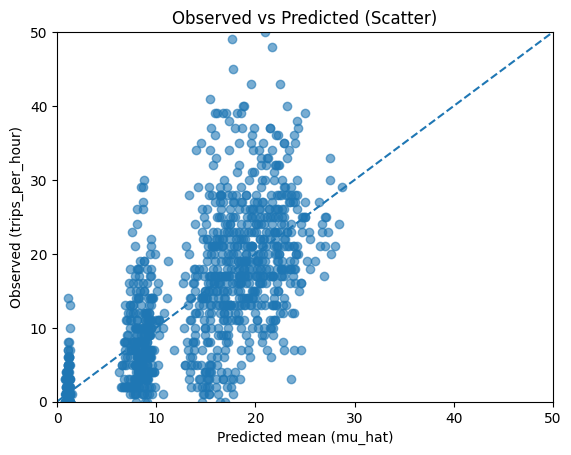

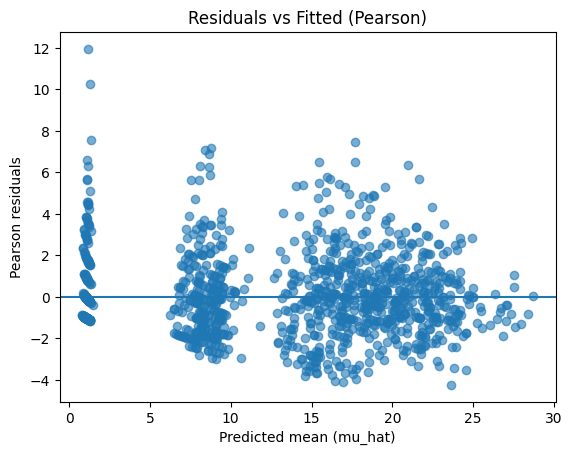

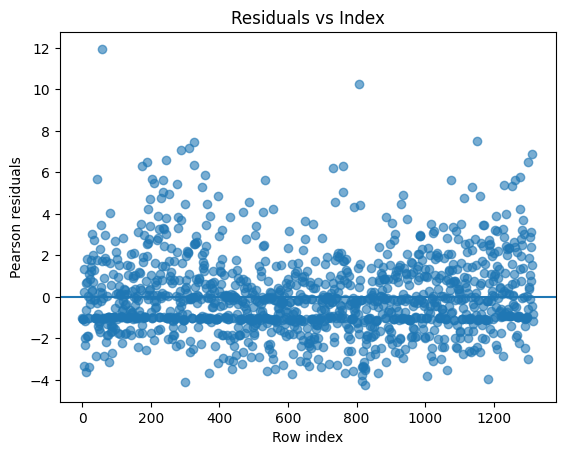

C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


,level_i,level_j,effect_log,se,z,p_raw,IRR,IRR_ci_low,IRR_ci_high,p_adj,reject_0.05
3,early_morning,late_afternoon,-2.878990,0.096499,-29.834434,1.397633e-195,0.056191,0.046508,0.067891,2.096450e-194,True
1,early_morning,peak_morning,-2.828973,0.095868,-29.508967,2.209066e-191,0.059073,0.048954,0.071285,3.092693e-190,True
2,early_morning,midday,-2.610366,0.096877,-26.945182,6.496228e-160,0.073508,0.060795,0.088878,8.445096e-159,True
0,early_morning,morning,-2.666499,0.104410,-25.538762,7.319547e-144,0.069495,0.056634,0.085277,8.783457e-143,True
4,early_morning,evening,-1.965909,0.098302,-19.998673,5.655721e-89,0.140029,0.115489,0.169782,6.221293e-88,True
14,late_afternoon,evening,0.913081,0.050844,17.958454,4.121247e-72,2.491990,2.255625,2.753123,4.121247e-71,True
11,peak_morning,evening,0.863064,0.050921,16.949021,1.956866e-64,2.370414,2.145256,2.619203,1.761180e-63,True
13,midday,evening,0.644457,0.051188,12.589959,2.397981e-36,1.904952,1.723106,2.105990,1.918385e-35,True
8,morning,evening,0.700590,0.071946,9.737759,2.080923e-22,2.014941,1.749931,2.320084,1.456646e-21,True
12,midday,late_afternoon,-0.268624,0.037667,-7.131617,9.919670e-13,0.764430,0.710028,0.823001,5.951802e-12,True


In [46]:
# Run the 6-segment model
out_model_6seg = run_poisson_model(base_df, model_6segment_spec)

### Optimal Segmentation (12 Segments - dispertion = 2.3038)


MODEL: Optimized 12-Segment Model - Target < 2.5 Dispersion
Formula: trips_per_hour ~ C(daytime_segment) + temp_c + wind_speed_ms
N rows: 1316
Dispersion (Pearson Chi2 / df_resid): 2.3038

                 Generalized Linear Model Regression Results                  
Dep. Variable:         trips_per_hour   No. Observations:                 1316
Model:                            GLM   Df Residuals:                     1302
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.2
Date:                Tue, 13 Jan 2026   Deviance:                       2944.3
Time:                        03:25:58   Pearson chi2:                 3.00e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9997
Covariance Type:                  HC0                                         
                    

,coef,std_err,z,p_value,ci_low,ci_high
term,,,,,,
Intercept,0.403736,0.116694,3.459781,5.406145e-04,0.175020,0.632452
C(daytime_segment)[T.early_morning],-1.382515,0.159602,-8.662266,4.624793e-18,-1.695329,-1.069701
C(daytime_segment)[T.morning_rush],0.737900,0.128310,5.750929,8.875427e-09,0.486417,0.989382
C(daytime_segment)[T.peak_morning],2.074170,0.107342,19.323073,3.435777e-83,1.863785,2.284556
C(daytime_segment)[T.mid_morning],2.709887,0.108546,24.965288,1.457134e-137,2.497140,2.922633
C(daytime_segment)[T.late_morning],2.429280,0.106646,22.778931,7.417858e-115,2.220258,2.638302
C(daytime_segment)[T.early_afternoon],2.148070,0.105648,20.332354,6.653320e-92,1.941004,2.355136
C(daytime_segment)[T.mid_afternoon],2.314459,0.107600,21.509885,1.258172e-102,2.103568,2.525351
C(daytime_segment)[T.late_afternoon],2.447215,0.106545,22.968793,9.563102e-117,2.238390,2.656039


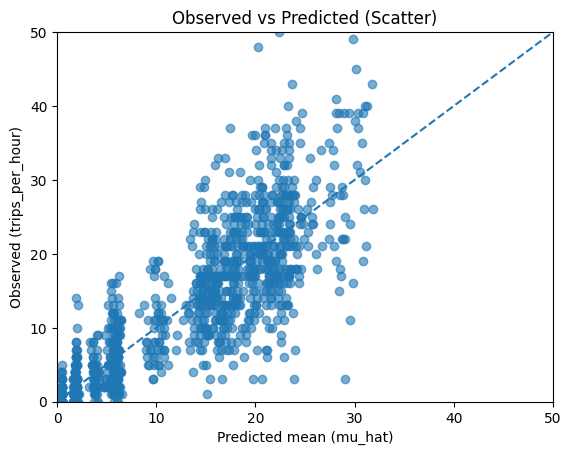

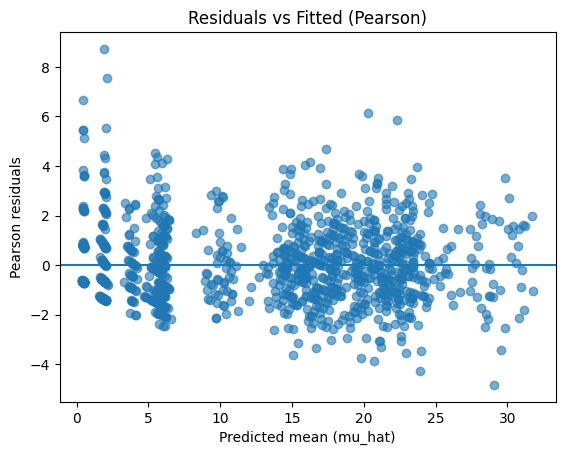

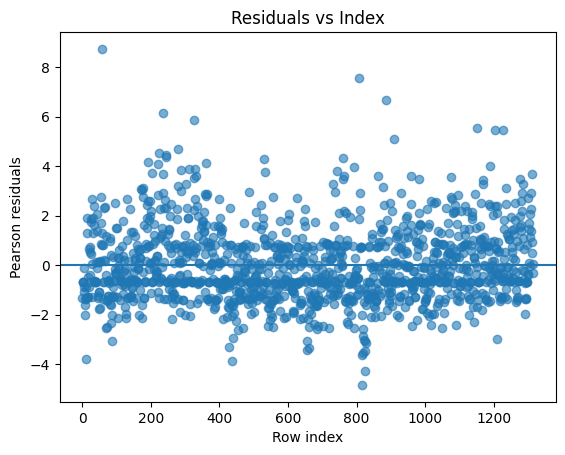

C:\Users\etaiw\AppData\Local\Temp\ipykernel_11128\1919046029.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_used[factor_col]):


,level_i,level_j,effect_log,se,z,p_raw,IRR,IRR_ci_low,IRR_ci_high,p_adj,reject_0.05
13,early_morning,mid_morning,-4.092401,0.132418,-30.905241,1.015678e-209,0.016699,0.012882,0.021648,6.703472e-208,True
17,early_morning,late_afternoon,-3.829730,0.130621,-29.319328,5.881865e-189,0.021715,0.016811,0.028052,3.823212e-187,True
14,early_morning,late_morning,-3.811795,0.130718,-29.160540,6.141651e-187,0.022108,0.017112,0.028565,3.930657e-185,True
16,early_morning,mid_afternoon,-3.696974,0.131409,-28.133308,3.835493e-174,0.024798,0.019168,0.032084,2.416361e-172,True
15,early_morning,early_afternoon,-3.530585,0.129694,-27.222430,3.524919e-163,0.029288,0.022714,0.037765,2.185450e-161,True
...,...,...,...,...,...,...,...,...,...,...,...
46,late_morning,mid_afternoon,0.114821,0.046947,2.445764,1.445454e-02,1.121672,1.023067,1.229781,7.227271e-02,False
53,early_afternoon,early_evening,0.123357,0.064465,1.913562,5.567610e-02,1.131288,0.997011,1.283650,2.227044e-01,False
32,peak_morning,early_afternoon,-0.073900,0.054205,-1.363324,1.727804e-01,0.928765,0.835151,1.032872,5.183412e-01,False
35,peak_morning,early_evening,0.049457,0.072353,0.683559,4.942536e-01,1.050701,0.911782,1.210785,9.885072e-01,False


In [47]:
optimized_12segment_spec = {
    "name": "Optimized 12-Segment Model - Target < 2.5 Dispersion",
    
    # Same filters
    "weekday_only": True,
    "no_rain_only": True,
    
    # Optimized boundaries based on post-hoc analysis
    # Key insights: Hours 6-7 very different from 9-10, hour 9 very different from 22
    "hour_seg": {
        "hour_col": "hour",
        "out_col": "daytime_segment",
        "edges": [0, 2, 6, 7, 8, 9, 11, 14, 16, 18, 19, 20, 24],  # Optimized boundaries
        "labels": [
            "deep_night",      # [0, 3): hours 0-2
            "early_morning",   # [3, 7): hours 3-6
            "morning_rush",    # [7, 8): hour 7
            "peak_morning",    # [8, 9): hour 8
            "mid_morning",     # [9, 10): hour 9
            "late_morning",    # [10, 12): hours 10-11
            "early_afternoon", # [12, 15): hours 12-14
            "mid_afternoon",   # [15, 17): hours 15-16
            "late_afternoon",  # [17, 19): hours 17-18
            "early_evening",   # [19, 20): hour 19
            "evening",         # [20, 21): hour 20
            "night"            # [21, 24): hours 21-23 (wait, this should be [21, 24): hours 21-23)
        ]
    },
    
    "terms": ["C(daytime_segment)", "temp_c", "wind_speed_ms"],
    "cov_type": "HC0",  # Keep robust SE - should work with optimized boundaries
    "plots": True,
    "axis_max": GLOBAL_AXIS_MAX,
    
    "posthoc": {
        "factor_col": "daytime_segment",
        "correction": "holm"
    }
}

out_12seg_final = run_poisson_model(base_df, optimized_12segment_spec)